In [94]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc
import os 

os.environ['OPENMC_CROSS_SECTIONS']='/home/sad_cat/openmc-setup-main/endfb-viii.0-hdf5/cross_sections.xml'


In [95]:


fuel = openmc.Material(name='fuel')
fuel.add_element('U', 1.0)
fuel.add_element('O', 2.0)
fuel.set_density('g/cm3', 10.0)

clad = openmc.Material(name='zircaloy')
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.0)

heavy_water = openmc.Material(name='heavy water')
heavy_water.add_nuclide('H2', 2.0)
heavy_water.add_nuclide('O16', 1.0)
heavy_water.add_s_alpha_beta('c_D_in_D2O')
heavy_water.set_density('g/cm3', 1.1)



/usr/local/lib/python3.10/dist-packages/openmc/surface.py:1538: FutureWarning: "ZCylinder(...) accepts an argument named 'r', not 'R'. Future versions of OpenMC will not accept the capitalized version.
  warn(_WARNING_UPPER.format(type(self).__name__, 'r', 'R'),
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=100.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=200.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=201.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=202.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=203.
  warn(msg, IDWarning)
/usr/local/lib/py

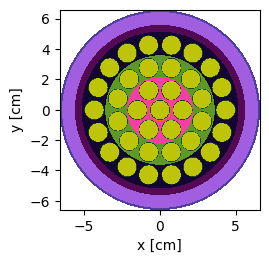

In [96]:


# Outer radius of fuel and clad
r_fuel = 0.6122
r_clad = 0.6540

# Pressure tube and calendria radii
pressure_tube_ir = 5.16890
pressure_tube_or = 5.60320
calendria_ir = 6.44780
calendria_or = 6.58750

# Radius to center of each ring of fuel pins
ring_radii = np.array([0.0, 1.4885, 2.8755, 4.3305])



# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(R=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    # Create annular region
    if i == 0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]
        
    water_cells.append(openmc.Cell(fill=heavy_water, region=water_region))

plot_args = {'width': (2*calendria_or, 2*calendria_or)}
bundle_universe = openmc.Universe(cells=water_cells)
surf_fuel = openmc.ZCylinder(R=r_fuel)

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
clad_cell = openmc.Cell(fill=clad, region=+surf_fuel)

pin_universe = openmc.Universe(cells=(fuel_cell, clad_cell))




num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, R=r_clad)
        water_cells[i].region &= +pin_boundary
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)


pt_inner = openmc.ZCylinder(R=pressure_tube_ir)
pt_outer = openmc.ZCylinder(R=pressure_tube_or)
calendria_inner = openmc.ZCylinder(R=calendria_ir)
calendria_outer = openmc.ZCylinder(R=calendria_or, boundary_type='vacuum')

bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
pressure_tube = openmc.Cell(fill=clad, region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region=+pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=clad, region=+calendria_inner & -calendria_outer)

root_universe = openmc.Universe(cells=[bundle, pressure_tube, v1, calendria])
root_universe.plot()

HexLattice
	ID             =	182
	Name           =	
	Orientation    =	y
	# Rings        =	7
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.384,)
	Outer          =	181
	Universes      
                  137
               137   137
            137   137   137
         137   137   137   137
      137   137   181   137   137
   137   137   137   137   137   137
137   137   181   137   181   137   137
   137   137   137   137   137   137
137   181   137   137   137   181   137
   137   137   137   137   137   137
137   137   137   137   137   137   137
   137   137   137   137   137   137
137   181   137   181   137   181   137
   137   137   137   137   137   137
137   137   137   137   137   137   137
   137   137   137   137   137   137
137   181   137   137   137   181   137
   137   137   137   137   137   137
137   137   181   137   181   137   137
   137   137   137   137   137   137
      137   137   181   137   137
         137   137   137   137
         

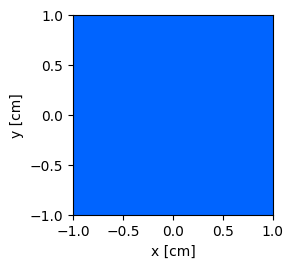

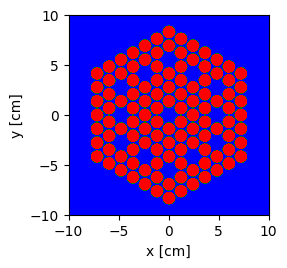

In [114]:

heavy_water_cell = openmc.Cell(fill=heavy_water)
heavy_water_univ = openmc.Universe(cells=[heavy_water_cell])
heavy_water_univ.plot(width=(2.0,2.0), color_by = 'material', colors = {heavy_water:(0,100,255)})


f_iz=root_universe
# Fuel assembly - inner zone

fa_iz = openmc.HexLattice()
fa_iz.center = (0., 0.)
fa_iz.pitch = (1.384,)
fa_iz.outer = heavy_water_univ
fa_iz.orientation = 'y'


outer_ring = [f_iz]*18*2

ring_1 = [f_iz]*30

ring_2 = [heavy_water_univ,f_iz]*12
ring_3 = [f_iz]*9*2

ring_4 = [f_iz]*12

ring_5 = [f_iz]*3*2

inner_ring = [heavy_water_univ]

fa_iz.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     inner_ring]
print(fa_iz)

top=openmc.ZPlane(120)
bottom=openmc.ZPlane(-120)

# Create the prism that will contain the lattice
outer_in_surface = openmc.model.hexagonal_prism(edge_length=7*1.384, orientation='y')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly = openmc.Cell(fill=fa_iz, region=outer_in_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_in_assembly  = openmc.Cell(fill=heavy_water, region=~outer_in_surface & -top & +bottom)

# Create a universe that contains both 
main_in_u = openmc.Universe(cells=[main_in_assembly, out_in_assembly])
dim=20
main_in_u.plot(width=(dim,dim),basis='xy',color_by='material',colors={heavy_water:'blue',fuel:'red',clad:'green'})